<a href="https://colab.research.google.com/github/AndreaMagnanini/AI-School/blob/main/ShapleyValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

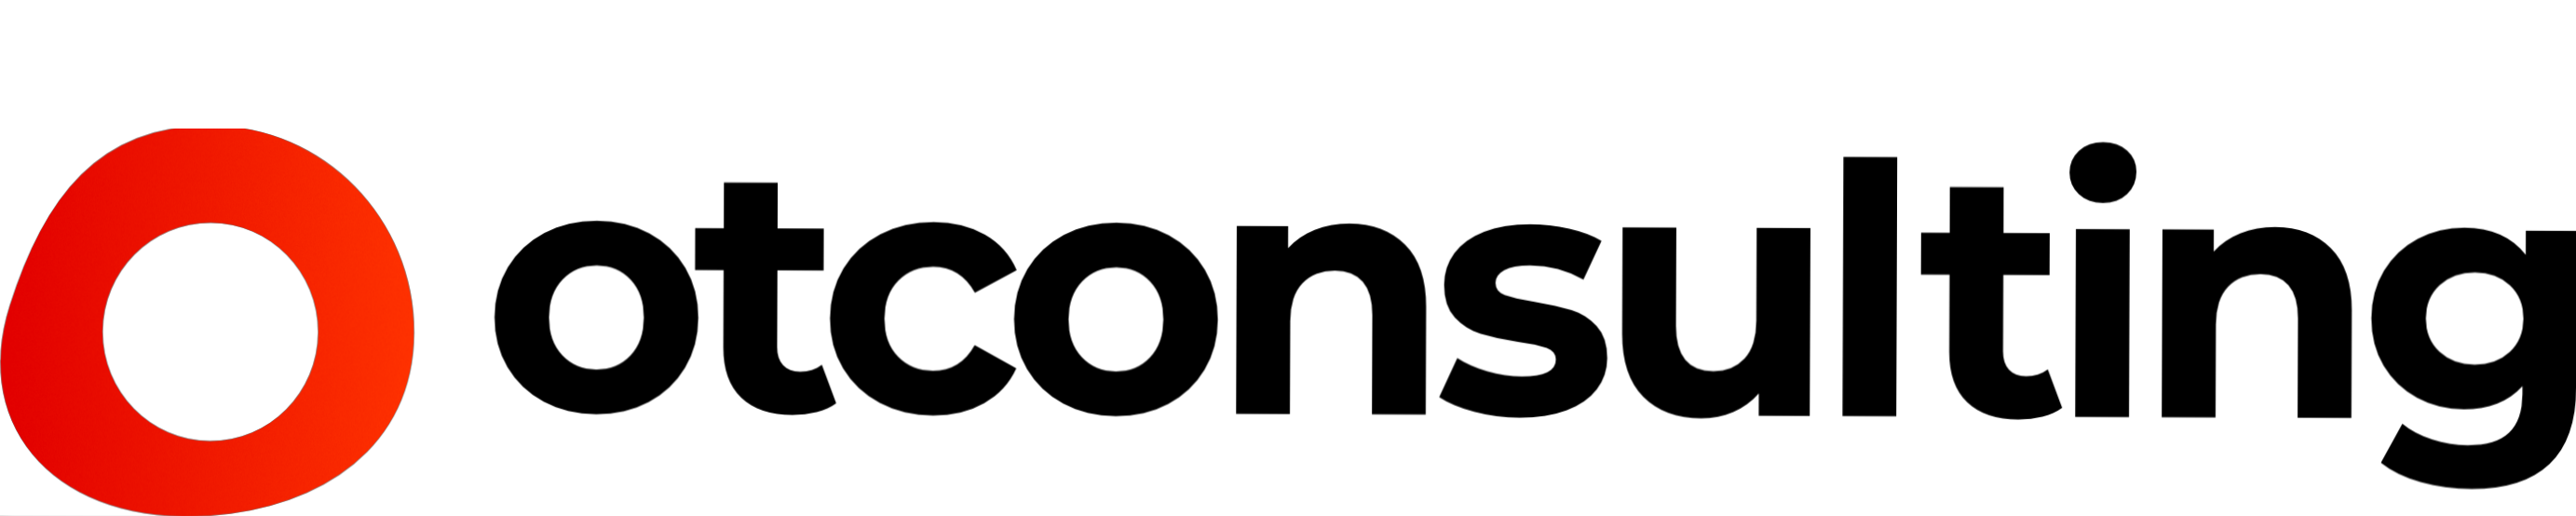

\begin{align}
  \text{}
\end{align}
\begin{align}
  \text{Progetto di}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
  \huge \text{ Scaltriti Federico}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
  \huge \text{ Magnanini Andrea}
\end{align}
\begin{align}
  \text{}
\end{align}
\begin{align}
 \text{per il Corso di Perfezionamento}
\end{align}
\begin{align}
  \text{}
\end{align}
<center>
<a href="https://aischools.it/"><img src="https://aischools.it/wp-content/uploads/2021/08/ai-logo.svg" width=400 /></a>
</center>

<div id="header" width=100%>
<table class="tfo-notebook-buttons" align="left" >
  <td>
    <a href="https://keras.io/"><img src="https://keras.io/img/logo.png" width="2050" >
      </a>
  </td>
  <td>
  <a href="https://www.tensorflow.org/"><img src="https://www.gstatic.com/devrel-devsite/prod/v24d520161c9661e427a3f6fa9973bfca56d0972dca82fa8ef65c709d915e80f3/tensorflow/images/lockup.svg"  width=2750 /></a>
  </td>
  <td>
     <a href="https://numpy.org/" ><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/NumPy_logo_2020.svg/2560px-NumPy_logo_2020.svg.png" width=1700 /></a>
  </td> 
  <td>
    <a href="https://pandas.pydata.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/2560px-Pandas_logo.svg.png" /></a>
  </td>
  <td>
    <a href="https://matplotlib.org/stable/index.html#"><img src="https://matplotlib.org/stable/_images/sphx_glr_logos2_003.png" width=2400 />
      </a>
  </td>
</table>
</div>


# <h1><center>Additive Shapley Values</center></h1>

<a><img src="https://github.com/slundberg/shap/blob/master/docs/artwork/shap_logo.png?raw=true"></a>
Rientra nell'insieme di tecniche di Feature Relevance Explanation.


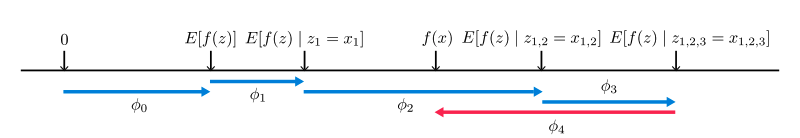


Assegna per ogni feature un valore di importanza per ogni predizione, attraverso l'individuazione di un'unica funzione che è soluzione del problema analizzato. \\
I valori di SHAP spiegano come passare dal valore di base $E[f(z)]$ (cioè il valore predetto se non fosse nota alcuna feature) al valore di output attuale $f(x)$. Il diagramma che segue illustra un ordinamento singolo. Al fine dell'ottenimento del valore previsto, quando il modello non è lineare o le input feature non sono indipendenti, è importante anche l'ordine in cui sono considerate per. In quel caso i valori di
SHAP si ottengono calcolando la media tra i valori $\phi_i$ in tutti i possibili ordini.

Il calcolo dei valori di SHAP non è semplice ma può essere approssimato per ottenere dei valori ad alta fedeltà come descritto da Lundberg e Lee.

# $\text{Startup}$

## <h3>Install SHAP package </h3>

In [ ]:
import sys
!{sys.executable} -m pip install shap

## <h3>Imports</h3>

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import nltk
import os
import json
import re
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## <h3>Model Loading</h3>

In [5]:
model_path = tf.keras.utils.get_file("model.h5", "https://github.com/AndreaMagnanini/AI-School/blob/main/Model.h5?raw=true")
model = tf.keras.models.load_model(model_path)
print(model.summary())
print(model)

2348760/2348760 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 64)           512064    
                                                                 
 dropout_27 (Dropout)        (None, 100, 64)           0         
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 528)               34320     
                                                                 
 dropout_29 (Dropout)        (None, 528)               0 

## <h3> Dataset Loading </h3>

In [6]:
df_reduced = pd.read_csv("https://raw.githubusercontent.com/AndreaMagnanini/AI-School/main/df_reduced.csv")
STOPWORDS = set(stopwords.words('italian'))

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('italian') + ['and', 'buongiorno', 'buonasera', 
                                              'buonpomeriggio', 'buon pomeriggio', 
                                              'buona sera', 'buon giorno', 
                                              'resi e rimborsi', 'ordini e spedizioni',
                                              'salve'])

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = str(text).lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [8]:
X = df_reduced["Text"]
X = X.apply(clean_text)
X = X.str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


## <h3>Tokenizer Loading</h3>

In [9]:
import urllib.request
with urllib.request.urlopen("https://github.com/AndreaMagnanini/AI-School/blob/main/tokenizer_subtype_alm_bal_2.pickle?raw=true") as handle:
  tokenizer = pickle.load(handle)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19708 unique tokens.


## <h3>Utils</h3>

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 8000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 64

In [11]:
classes = np.unique(df_reduced["Subtype"])
classes

array(['Change / cancel order', 'Delivery errors', 'FC Other',
       'Failed pick-up', 'Fit and measurements', 'Order information',
       'Other', 'Payment problems', 'Products availability',
       'Products info', 'Return instructions and timings',
       'Return procedure authorization', 'Shipment progress',
       'Undeliverable order'], dtype=object)

# $\text{Shapley Values Implementation with SHAP}$

<center>
<a href="https://github.com/slundberg/shap"><img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.svg"/></a>
</center>

In [14]:
import shap

def f(x):
    x_token = tokenizer.texts_to_sequences(np.asarray(x))
    text_data = pad_sequences(x_token, maxlen=MAX_SEQUENCE_LENGTH)
    return model.predict(text_data)

In [15]:
masker=shap.maskers.Text(tokenizer=r"\W+")

In [16]:
def get_subtype(str):
    index = X[X==str].index[0]
    row = df_reduced.loc[[index]]
    subtype = row["Subtype"].values
    return subtype[0], index

In [17]:
explainer = shap.Explainer(f, masker=masker, output_names=classes)

# $\text{Example: correct prediction}$

In [ ]:
shaps = explainer(X[:3])

In [20]:
shap.initjs()
shap.plots.text(shaps)

# $\text{Example: correct prediction, wrong decisions}$

# $\text{Example: wrong prediction}$